In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

No handles with labels found to put in legend.


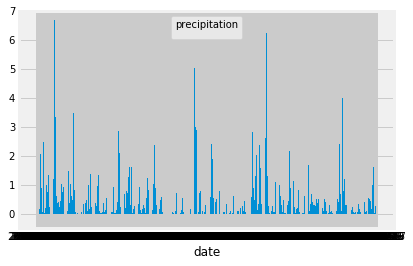

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
inspector.get_table_names()

#just used to inspect types from dataset
#columns = inspector.get_columns('measurement')
#for c in columns:
    #print(c['name'], c["type"])

#sorting by most recent dates and setting variable for that
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#set first four digts of date field as a variable and change to int for formatting
year = int(latest_date[0][:4])
#set variable for 2016 dates...this represents 2017-1 which equals 2016
last_year = year-1
#change last year back to string for query purpose...also adding characters 4-10 
#from the most recent date above
last_years=str(last_year)+latest_date[0][4:10]
last_years

#use dt query to return everything greater than or equal to one year prior the latest date
months = session.query(Measurement.date,Measurement.prcp,Measurement.station,Measurement.tobs).filter(Measurement.date>=last_years).all()
months

#pull out date and precip from tuples
date = [date[0] for date in months]
precip = [precip[1] for precip in months]

#put into dataframe and drop NaN's
df = pd.DataFrame(
    {'Date': date,
     'Precip': precip
    })
df = df.dropna()

#plot the graph
plt.bar(df['Date'],df['Precip'])
plt.xlabel("date")
plt.ylim(-0.5,7)
plt.legend(title="precipitation",loc='upper center')
plt.grid(True)
plt.savefig("Graphs/precipitation.png")
plt.show()




In [110]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe(include=[np.number])

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [111]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).\
    group_by(Measurement.station).count()
stations

9

In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).all()
station_counts
#sort return by the second element of the tuple, which is date counts
import operator
station_counts.sort(key = operator.itemgetter(1), reverse = True)
print(station_counts)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [115]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#use list comp. to pull out station id from the number 1 position in station counts
station_id = [result[0] for result in station_counts[:1]]
station_id_use = station_id[0]
station_id_use
#run functions and filter based on the station ID that was pulled out above
station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == station_id_use).all()
station_data

[(54.0, 85.0, 71.66378066378067)]

<Figure size 432x288 with 0 Axes>

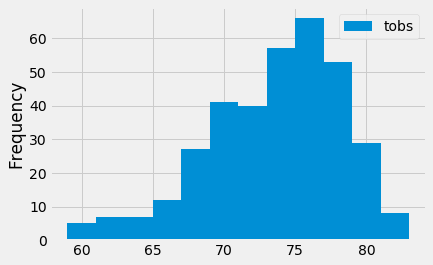

In [139]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active = session.query(Measurement.tobs).filter(Measurement.date>=last_years).filter(Measurement.station==station_id_use).all()
#use list comp. to pull out temps from tuples
temps_extract = [temp[0] for temp in most_active]
temps_extract
temps_extract_df = pd.DataFrame(temps_extract, columns=['tobs'])
#plot histogram
plt.figure()
temps_extract_df.plot.hist(temps_extract, bins=12)
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.savefig("Graphs/temperature.png")
plt.show()
